In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score ,confusion_matrix
import matplotlib.pyplot as plt

Učitavanje predprocesiranih podataka

In [2]:
news = pd.read_csv('data/vesti.csv')
news.info()
news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198627 entries, 0 to 198626
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  198627 non-null  int64 
 1   text        198626 non-null  object
 2   category    198627 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.5+ MB


,Unnamed: 0,text,category
0,36290,shall overcomb say march trump london thousand...,WOMEN
1,21194,bone didnt teach glamour taught respect oftent...,HEALTHY LIVING
2,29672,im sorrythe two tragically forgotten word cust...,BUSINESS
3,199048,divorce ruin life child blame sunday night luc...,DIVORCE
4,193783,well sit civilian flea theater civilian enterp...,DIVORCE


Zbog lošijeg modela, u pokušaju bolje klasifikacije izdvajamo 10 klasa koje su se pokazale najbolje na modelu sa 36 klasa.

In [3]:
categories = ['DIVORCE', 'WEDDINGS', 'STYLE AND BEAUTY', 'QUEER VOICES', 'POLITICS', 'HOME & LIVING', 'TRAVEL', 'WORLD NEWS', 'SPORTS', 'ENTERTAINMENT']
news = news[news.category.isin(categories)]



In [4]:

news.info()
categories = news.groupby('category')
print("UKUPAN BROJ RAZLIČITIH KATEGORIJA: ", categories.ngroups)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100100 entries, 3 to 198626
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100100 non-null  int64 
 1   text        100100 non-null  object
 2   category    100100 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.1+ MB
UKUPAN BROJ RAZLIČITIH KATEGORIJA:  10


Podela podataka i vektorizacija.

In [5]:
X = news['text']
y = news['category']

In [6]:
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size = 0.33, stratify = y, random_state = 4)

In [7]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
tfidf_vectorizer.fit(X_train.values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [8]:
X_train = tfidf_vectorizer.transform(X_train.values.astype('U'))
X_test = tfidf_vectorizer.transform(X_test.values.astype('U'))
y_train = y_train.astype('category')
y_test = y_test.astype('category')


Kodiranje kategoričkih klasa.

In [9]:
classes = dict(enumerate(y_train.cat.categories))
y_train = y_train.cat.codes
y_test = y_test.cat.codes
print(classes)

{0: 'DIVORCE', 1: 'ENTERTAINMENT', 2: 'HOME & LIVING', 3: 'POLITICS', 4: 'QUEER VOICES', 5: 'SPORTS', 6: 'STYLE AND BEAUTY', 7: 'TRAVEL', 8: 'WEDDINGS', 9: 'WORLD NEWS'}


Multinomijalna Bajes klasifikacija je urađena sa više razlicitih paramaetara Alfa. Primećeno je da manji parametri daju bolje rezeltate. Na kraju je izdvojen najbolji parametar i njegov najbolji rezultat.

In [26]:
alphas=[0.005,0.006,0.007,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
best_acc=0
best_alpha=None
bayesArray=[]
for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_predict)
    bayesArray.append(accuracy)
    if accuracy> best_acc:
        best_acc = accuracy
        best_alpha = alpha
print('Najbolja preciznost na test skupu je: ', best_acc)
print('Najbolji alfa parametar modela su: ', best_alpha)


Najbolja preciznost na test skupu je:  0.8712802349165986
Najbolji alfa parametar modela su:  0.04


Grafički prikaz zavisnosti rezultata klasifikacije od parametra.

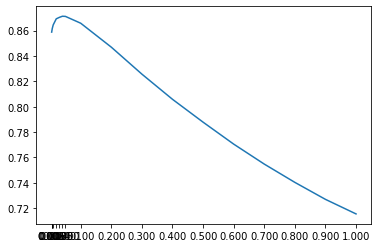

In [27]:
plt.plot(alphas,bayesArray)
plt.xticks(alphas)
plt.show()


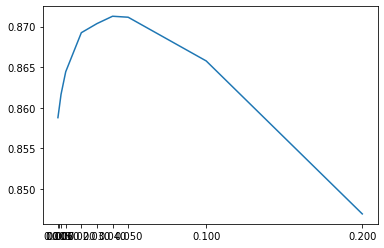

In [29]:
plt.plot(alphas[0:10],bayesArray[0:10])
plt.xticks(alphas[0:10])
plt.show()

In [35]:
model = MultinomialNB(alpha=alpha)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
matrix=metrics.confusion_matrix(y_test, y_test_predicted)
print(matrix)

[[  904    55     8    56     8     5    21    17    47     5]
 [   21  4777     5   263    30    39    78    41    11    22]
 [    0    23  1134    37     3     1    77    61     3     3]
 [    1   114     4 10227    55    30    14    34     4   265]
 [   18   116     1   214  1628    18    13    21    15    33]
 [    3   121     1   140    11  1275     9    14     1    35]
 [   10   149    21    77     7     6  3292    56    15     8]
 [    1    55    10    79     1     9    56  2985    10    39]
 [   48    46     9    26    12     5    49    24   961     3]
 [    2    49     4   500     9    12     5    54     2  2137]]


Iz matrice konfuzije primećujemo da su neka izraženija odtupanja kod klase World news, koja se pogrešno klasifikuje u oblast Politics.

U nastavku je data klasifikacija pomoću knn metode. Sa porastom broja najbližih suseda raste i preciznost modela i u našem slučaju najbolji model dobijamo za 15 suseda.

In [30]:
n_neighbors_list=list(range(1, 21))
best_acc_test=0
best_acc_train=0
best_n=None
knnArray=[]
for n_neighbors in n_neighbors_list:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X_test)
    accuracy_test = accuracy_score(y_test,y_predict)
    knnArray.append(accuracy_test)
  #  accuracy_train = knn_model.score(X_train, y_train)
    if accuracy_test> best_acc_test:
        best_acc_test = accuracy_test
   #     best_acc_train=accuracy_train
        best_n = n_neighbors
print('Najbolji rezultat na test skupu je: ',best_acc_test)
print('Najbolji parametri modela su: ', best_n)

Najbolji rezultat na test skupu je:  0.8451851179123906
Najbolji parametri modela su:  19


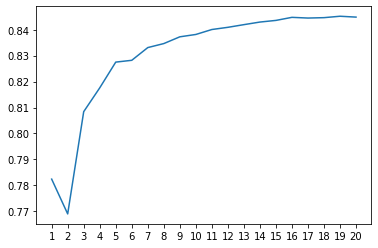

In [31]:
plt.plot(n_neighbors_list,knnArray)
plt.xticks(n_neighbors_list)
plt.show()


In [38]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=best_n)
knn_model.fit(X_train, y_train)
y_predict = knn_model.predict(X_test)
matrix=metrics.confusion_matrix(y_test, y_predict)
print(matrix)

[[  889    71    12    60     9     4    30    12    38     1]
 [   29  4607    11   344    37    47   143    41     9    19]
 [    6    45  1104    52     3     5    73    44     6     4]
 [   10   138     9 10197    43    38    19    55     3   236]
 [   24   183     8   320  1402    23    29    31    23    34]
 [    7   121     2   215    17  1183     8    20     4    33]
 [   23   302    36   110    12    11  3052    69    17     9]
 [   11   102    43   172    14    21    79  2727    16    60]
 [   63    75    21    61    15     5    37    37   865     4]
 [    4    65    15   685    19    12    20    60     1  1893]]


Može se primetiti da se slične zamene klasa dešavaju kao u slučaju NB klsifikacije.

U nastavku su data dva modela, gde se gleda razlika jedne klase u odnosu na ostale i razlika izmedju dve klase. Rezultati su približno isti.

In [11]:
ovr = multiclass.OneVsRestClassifier(svm.LinearSVC())
ovr.fit(X_train, y_train)
y_predicted_ovr = ovr.predict(X_test)
print(metrics.classification_report(y_test, y_predicted_ovr))
print(metrics.confusion_matrix(y_test, y_predicted_ovr))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1126
           1       0.89      0.90      0.90      5287
           2       0.94      0.90      0.92      1342
           3       0.91      0.94      0.93     10748
           4       0.91      0.84      0.87      2077
           5       0.90      0.85      0.87      1610
           6       0.92      0.92      0.92      3641
           7       0.91      0.93      0.92      3245
           8       0.89      0.85      0.87      1183
           9       0.83      0.81      0.82      2774

    accuracy                           0.90     33033
   macro avg       0.90      0.88      0.89     33033
weighted avg       0.90      0.90      0.90     33033

[[  962    33     9    21    10     3    16    16    51     5]
 [   23  4767     9   212    47    57    87    42    14    29]
 [    2    13  1202    19     2     1    50    46     4     3]
 [    4   113     5 10147    64    41    14    44   

In [47]:
ovo = multiclass.OneVsOneClassifier(svm.LinearSVC())
ovo.fit(X_train, y_train)
y_predicted_ovo = ovo.predict(X_test)
print(metrics.classification_report(y_test, y_predicted_ovo))
print(metrics.confusion_matrix(y_test, y_predicted_ovo))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1126
           1       0.88      0.90      0.89      5287
           2       0.94      0.87      0.91      1342
           3       0.90      0.94      0.92     10748
           4       0.92      0.82      0.87      2077
           5       0.90      0.82      0.86      1610
           6       0.91      0.91      0.91      3641
           7       0.91      0.92      0.92      3245
           8       0.88      0.84      0.86      1183
           9       0.83      0.80      0.82      2774

    accuracy                           0.90     33033
   macro avg       0.90      0.87      0.88     33033
weighted avg       0.90      0.90      0.90     33033

[[  940    52     7    30     7     2    17    15    54     2]
 [   22  4775     8   226    34    55    85    43    16    23]
 [    1    16  1174    28     2     1    67    47     3     3]
 [    4   132     2 10139    67    40    14    39   

Od isprobanih modela nešto lošije se pokazao KNN algoritam, dok su nešto bolji bili poslednja dva. Takođe poslednja dva modela smanjuju problem između problematičnih kategorija u odnosu na KNN i Bayes.